In [1]:
from pycoingecko import CoinGeckoAPI
from datetime import datetime, timezone, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# cg = CoinGeckoAPI()

Timestamp returned by this API are in UTC Timezone.

In [241]:
I = int((datetime(2021,2,16)-datetime(2018, 5, 25)).days/90)


In [242]:
# dt = datetime(2021, 2, 10)
# from_timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

prices_pd_arr = []
dt = datetime(2018, 5, 25)
for i in range(I):
    from_timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

    dt = dt+timedelta(days=+90)
    to_timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

    prices = cg.get_coin_market_chart_range_by_id(id='bitcoin',
                                         vs_currency='USD',
                                         from_timestamp = from_timestamp,
                                         to_timestamp= to_timestamp)
    prices_pd = pd.DataFrame(prices['prices'])
    prices_pd_arr.append(prices_pd)


KeyboardInterrupt: 

In [362]:
last_timestamp = datetime(2021,2,17)
last_timestamp = last_timestamp.replace(tzinfo=timezone.utc).timestamp()
prices = cg.get_coin_market_chart_range_by_id(id='bitcoin',
                                     vs_currency='USD',
                                     from_timestamp = to_timestamp,
                                     to_timestamp= last_timestamp)
prices_pd = pd.DataFrame(prices['prices'])
prices_pd_arr.append(prices_pd)

In [454]:
results = pd.concat(prices_pd_arr)
results = results.drop_duplicates()
results.columns = ['UTC_time', 'bitcoin price']

In [ ]:
results.loc[:,'UTC_time'] = pd.to_datetime(results.loc[:,'UTC_time']*1000000)
results.loc[:,'berlin_time'] = results.loc[:,'UTC_time'].apply(lambda x: x+timedelta(hours=1))
results.loc[:,'berlin_time_date'] = results.loc[:,'UTC_time'].apply(lambda x: x.date())
results.loc[:,'berlin_time_hour'] = results.berlin_time.apply(lambda x:x.hour)
results.loc[:,'berlin_time_min'] = results.berlin_time.apply(lambda x:x.minute)
results.reset_index(drop=True, inplace=True)

In [468]:
results.to_csv('bitcoin_hourly_price_coingecko_raw.csv')

In [4]:
def time_diff(x, target_hour):
    y = x.year
    m = x.month
    d = x.day 
    return np.abs((x - datetime(y,m,d,target_hour)).total_seconds())

In [5]:
results.loc[:,'D'] = results.berlin_time.apply(lambda x: time_diff(x, 23))

AttributeError: 'str' object has no attribute 'year'

In [238]:
results.loc[:,'D'] = results.berlin_time.apply(lambda x: time_diff(x, 23))

AttributeError: 'str' object has no attribute 'year'

In [57]:
results = pd.read_csv('../data/btc future and reference rate/bitcoin_hourly_price_coingecko_raw.csv')

In [58]:
date_arr = results.berlin_time_date.unique()

closest_to_23 = []

for date in date_arr:
    _id = results.berlin_time_date==date
    closest_to_23.append(np.argmin(results.loc[_id,'D']))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [59]:
bitcoin_price = results.iloc[closest_to_23,:].loc[:,['berlin_time_date', 'bitcoin price']]

In [60]:
bitcoin_price.reset_index(drop=True, inplace=True)

In [61]:
future = pd.read_excel('../data/btc future and reference rate/btc_future.xlsx')
future = future.dropna()

In [62]:
future.Date = pd.to_datetime(future.Date)

In [63]:
bitcoin_price.loc[:,'Date']=pd.to_datetime(bitcoin_price.berlin_time_date)

In [64]:
df = bitcoin_price.merge(future, how='inner', on='Date').loc[:,['Date', 'bitcoin price', 'Close']]
df.dropna(inplace=True)
df.sort_values('Date', ascending= False, inplace=True)
df.reset_index(drop=True, inplace=True)

In [65]:
df.loc[:,'log return bitcoin'] = np.log(df.iloc[:,1]/df.iloc[:,1].shift(-1))

In [66]:
df.loc[:,'log return future'] = np.log(df.iloc[:,2]/df.iloc[:,2].shift(-1))


In [67]:
df.dropna(inplace=True)

In [68]:
df.to_csv('../data/btc future and reference rate/coingecko_future.csv')

In [69]:
df.head()

,Date,bitcoin price,Close,log return bitcoin,log return future
0,2021-02-03,37266.377988,37790.0,0.045299,0.033774
1,2021-02-02,35615.923864,36535.0,0.059664,0.064146
2,2021-02-01,33553.086495,34265.0,-0.041523,-0.026353
3,2021-01-29,34975.625836,35180.0,0.052253,0.061398
4,2021-01-28,33194.978393,33085.0,0.067181,0.036317


In [70]:
import os
filename = 'coingecko_future_v5'
path = "../processed_data/"+ filename+"/"
if not os.path.exists(path):
    os.mkdir(path)
    os.mkdir(path+'train/')
    os.mkdir(path+'test/')
    

In [71]:
train_size = 300
test_size = 100 
step_size = 5 

n = int(np.floor((len(df)-train_size-test_size)/step_size))

train_set = []
test_set = []

for i in range(n):
    data = df.iloc[(i*step_size):((i)*step_size)+train_size+test_size]
    test = data.iloc[:test_size,]
    train = data.iloc[test_size:,]
    train_set.append(train)
    test_set.append(test)

for i in range(len(train_set)):
    train_set[i].to_csv(path+'train/'+str(i)+".csv")
    test_set[i].to_csv(path+'test/'+str(i)+".csv")

In [73]:
df

,Date,bitcoin price,Close,log return bitcoin,log return future
0,2021-02-03,37266.377988,37790.0,0.045299,0.033774
1,2021-02-02,35615.923864,36535.0,0.059664,0.064146
2,2021-02-01,33553.086495,34265.0,-0.041523,-0.026353
3,2021-01-29,34975.625836,35180.0,0.052253,0.061398
4,2021-01-28,33194.978393,33085.0,0.067181,0.036317
5,2021-01-27,31038.167807,31905.0,-0.031028,-0.020475
6,2021-01-26,32016.318284,32565.0,-0.012835,-0.049280
7,2021-01-25,32429.912048,34210.0,-0.032341,-0.001606
8,2021-01-22,33495.880668,34265.0,0.068315,0.050733
9,2021-01-21,31284.024401,32570.0,-0.110154,-0.096649


In [72]:
test_set[0].tail()

,Date,bitcoin price,Close,log return bitcoin,log return future
95,2020-09-17,10959.107673,10950.0,-0.005249,-0.005919
96,2020-09-16,11016.788324,11015.0,0.015720,0.018324
97,2020-09-15,10844.956029,10815.0,0.010277,0.010223
98,2020-09-14,10734.073851,10705.0,0.036930,0.034691
99,2020-09-11,10344.894473,10340.0,0.000183,0.002421


In [48]:
train_set[-2].head()

,Date,bitcoin price,Close,log return bitoin,log return future
365,2019-08-22,10111.460266,10275.0,0.002106,0.006346
366,2019-08-21,10090.188837,10210.0,-0.068070,-0.060337
367,2019-08-20,10800.939830,10845.0,0.008204,0.001384
368,2019-08-19,10712.689131,10830.0,0.026051,0.019110
369,2019-08-16,10437.216342,10625.0,0.009652,0.036908


https://www.coingecko.com/en/methodology

1. Price (Cryptoasset)
The price of a cryptoasset is calculated based on the pairings available and collected by CoinGecko from the various exchanges for a particular cryptoasset. The price shown on CoinGecko for a particular cryptoasset is calculated using a global volume-weighted average price formula.
Example 1 (Different fiat pairings)

Using Bitcoin (BTC) as an example, and assuming we only track two exchanges, A and B which trades in USD and JPY:

Exchange A: BTC/USD = USD 1,000 / BTC @ 15,000 BTC Trading Volume (rolling 24 hours)
Exchange B: BTC/JPY = JPY 109,000 / BTC @ 10,000 BTC Trading Volume (rolling 24 hours)
CoinGecko will first convert JPY to USD using FX rates provided by OpenExchangeRates. Assuming USD 1 = JPY 110, this will mean:

Exchange B: BTC/JPY = JPY 109,000 / BTC ≈ USD 990 / BTC

CoinGecko will then calculate the global volume-weighted average price. In this case, it will be:

CoinGecko BTC Price (USD)
= [Volume % * USD Price] + [Volume % * Converted USD Price]
= [ 15,000 / (15,000 + 10,000) ] * USD 1,000 + [ 10,000 / (15,000 + 10,000) ] * USD 990
= 0.6 * USD 1,000 + 0.4 * USD 990
= USD 996
Example 2 (Fiat & other crypto pairings)

Using Ethereum (ETH) as an example, and assuming we only track two exchanges, A and B which trades in USD and BTC:
Exchange A: ETH/USD = USD 200 / ETH @ 30,000 ETH Trading Volume (rolling 24 hours)
Exchange B: ETH/BTC = ₿ 0.20000000 / ETH @ 20,000 ETH Trading Volume (rolling 24 hours)
CoinGecko will first convert the ETH/BTC price to a USD price using the CoinGecko BTC Price derived above. Assuming 1 BTC = USD 996, this will mean:
Exchange B: ETH/BTC = ₿ 0.20000000 / ETH ≈ USD 199.2 / ETH

CoinGecko will then calculate the global volume-weighted average price. In this case, it will be:

CoinGecko ETH Price (USD)
= [ 30,000 / (30,000 + 20,000) ] * USD 200 + [ 20,000 / (30,000 + 20,000) ] * USD 199.2
= 0.6 * USD 200 + 0.4 * USD 199.2
= USD 199.68

From Example 1 and 2, the prices obtained in USD are then converted into other local currencies such as GBP, CNY, JPY, EUR and so on using OpenExchangeRates and then displayed on CoinGecko.

Note: CoinGecko’s global volume-weighted average price calculation excludes data points that are detected as outliers as explained in Part 3 below.



In [2]:
BTC_data = pd.read_csv('../data/btc future and reference rate/bitcoin_hourly_price_coingecko_raw.csv')

In [11]:
BTC_data.head()

,Unnamed: 0,UTC_time,bitcoin price,berlin_time,berlin_time_date,berlin_time_hour,berlin_time_min,D
0,0,2018-05-25 00:31:22.637,7560.112715,2018-05-25 01:31:22.637,2018-05-25,1,31,77317.363
1,1,2018-05-25 01:31:21.861,7534.214536,2018-05-25 02:31:21.861,2018-05-25,2,31,73718.139
2,2,2018-05-25 02:31:21.851,7592.604368,2018-05-25 03:31:21.851,2018-05-25,3,31,70118.149
3,3,2018-05-25 03:26:59.595,7609.411850,2018-05-25 04:26:59.595,2018-05-25,4,26,66780.405
4,4,2018-05-25 03:31:40.564,7611.921502,2018-05-25 04:31:40.564,2018-05-25,4,31,66499.436


In [30]:
df = BTC_data.groupby('berlin_time_date').count()
df.loc[df.iloc[:,0] <24, :]

,Unnamed: 0,UTC_time,bitcoin price,berlin_time,berlin_time_hour,berlin_time_min,D
berlin_time_date,,,,,,,
2018-09-26,22,22,22,22,22,22,22
2018-11-01,20,20,20,20,20,20,20
2018-12-05,22,22,22,22,22,22,22
2018-12-13,21,21,21,21,21,21,21
2019-01-29,23,23,23,23,23,23,23
2019-03-09,22,22,22,22,22,22,22
2019-03-22,23,23,23,23,23,23,23
2019-03-26,16,16,16,16,16,16,16
2019-03-27,22,22,22,22,22,22,22


In [31]:
BTC_data.loc[BTC_data.berlin_time_date == '2019-03-26',:]

,Unnamed: 0,UTC_time,bitcoin price,berlin_time,berlin_time_date,berlin_time_hour,berlin_time_min,D
7504,7504,2019-03-26 00:03:09.070,3927.577297,2019-03-26 01:03:09.070,2019-03-26,1,3,79010.930
7505,7505,2019-03-26 01:12:17.510,3933.061742,2019-03-26 02:12:17.510,2019-03-26,2,12,74862.490
7506,7506,2019-03-26 02:01:06.223,3931.060009,2019-03-26 03:01:06.223,2019-03-26,3,1,71933.777
7507,7507,2019-03-26 03:03:46.524,3942.047721,2019-03-26 04:03:46.524,2019-03-26,4,3,68173.476
7508,7508,2019-03-26 04:13:18.757,3934.671480,2019-03-26 05:13:18.757,2019-03-26,5,13,64001.243
7509,7509,2019-03-26 06:15:08.911,3934.021287,2019-03-26 07:15:08.911,2019-03-26,7,15,56691.089
7510,7510,2019-03-26 07:03:06.841,3922.027530,2019-03-26 08:03:06.841,2019-03-26,8,3,53813.159
7511,7511,2019-03-26 08:03:12.805,3915.069169,2019-03-26 09:03:12.805,2019-03-26,9,3,50207.195
7512,7512,2019-03-26 09:03:04.796,3935.195224,2019-03-26 10:03:04.796,2019-03-26,10,3,46615.204
7513,7513,2019-03-26 10:02:09.334,3928.574225,2019-03-26 11:02:09.334,2019-03-26,11,2,43070.666


In [3]:
future_data = pd.read_excel('../data/btc future and reference rate/btc_future.xlsx')

In [4]:
CRIX_data =  pd.read_json('../data/crix.json')

In [5]:
CRIX_data.date = CRIX_data.date  - pd.DateOffset(1)

In [6]:
CRIX_data

,date,price
0,2014-07-30,1000.000000
1,2014-07-31,1018.202717
2,2014-08-01,1008.772389
3,2014-08-02,1004.416500
4,2014-08-03,1004.984138
5,2014-08-04,998.041056
6,2014-08-05,999.866318
7,2014-08-06,1006.144005
8,2014-08-07,1012.505635
9,2014-08-08,1006.846193


In [8]:
future_data

,Date,Open,High,Low,Close,Open Interest,SMAVG (15)
0,2021-02-04,38080.0,39655.0,37685.0,38220.0,NaN,NaN
1,2021-02-03,36360.0,38155.0,36240.0,37790.0,2795.0,2091.0
2,2021-02-02,34205.0,36665.0,34070.0,36535.0,2755.0,2010.0
3,2021-02-01,33715.0,35280.0,32800.0,34265.0,2647.0,1929.0
4,2021-01-29,33995.0,39530.0,32590.0,35180.0,2635.0,1853.0
5,2021-01-28,31005.0,33710.0,30350.0,33085.0,2438.0,1772.0
6,2021-01-27,33440.0,33440.0,29615.0,31905.0,2202.0,1705.0
7,2021-01-26,33100.0,33490.0,31370.0,32565.0,2016.0,1648.0
8,2021-01-25,32860.0,35795.0,32825.0,34210.0,1838.0,1602.0
9,2021-01-22,31625.0,34555.0,29750.0,34265.0,1834.0,1566.0


In [9]:
CRIX_future = CRIX_data.merge(future_data, left_on='date', right_on='Date')

In [10]:
CRIX_future = CRIX_future.dropna()
CRIX_future.head()

,date,price,Date,Open,High,Low,Close,Open Interest,SMAVG (15)
15,2018-01-08,57166.86602,2018-01-08,16415.0,16415.0,14150.0,15030.0,246.0,127.0
16,2018-01-09,56403.97559,2018-01-09,15260.0,15390.0,14405.0,14855.0,270.0,145.0
17,2018-01-10,51050.86457,2018-01-10,14530.0,14800.0,13705.0,14530.0,258.0,161.0
18,2018-01-11,55542.84586,2018-01-11,14780.0,14890.0,12830.0,13425.0,260.0,175.0
19,2018-01-12,57821.91428,2018-01-12,13390.0,13965.0,13365.0,13975.0,267.0,188.0


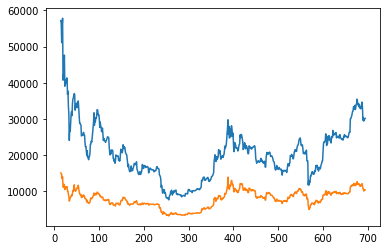

In [11]:
plt.plot(CRIX_future.price)
plt.plot(CRIX_future.Close)

In [12]:
CRIX_future = CRIX_future.loc[:,['date', 'price', 'Close']] 
CRIX_future.columns = ['date', 'CRIX', 'future']
CRIX_future.set_index('date', inplace=True)

In [13]:
CRIX_price = CRIX_future.CRIX
future_price = CRIX_future.future

In [14]:
CRIX_future_logreturns = np.log(CRIX_future/CRIX_future.shift(1))

In [53]:
CRIX_future.to_csv('../data/btc future and reference rate/CRIX_future.csv')

In [64]:
results = CRIX_future.merge(CRIX_future_logreturns, on='date')
results.columns = ['CRIX', 'future', 'log return CRIX', 'log return future']
results = results.iloc[1:, :]
results.sort_index(ascending=False, inplace=True)
results

,CRIX,future,log return CRIX,log return future
date,,,,
2020-09-11,30129.172384,10340.0,0.004080,0.002421
2020-09-10,30006.484814,10315.0,0.011578,-0.000485
2020-09-09,29661.064542,10320.0,0.010107,0.030000
2020-09-08,29362.798925,10015.0,-0.033305,-0.058655
2020-09-04,30357.206771,10620.0,0.024776,-0.009372
2020-09-03,29614.314902,10720.0,-0.109754,-0.066752
2020-09-02,33049.664458,11460.0,-0.046514,-0.052274
2020-09-01,34623.237089,12075.0,0.023061,0.020076
2020-08-31,33833.920615,11835.0,0.016390,0.017473


In [65]:
from statsmodels.distributions.empirical_distribution import ECDF

CRIX = CRIX_future_logreturns.iloc[:,0]
future = CRIX_future_logreturns.iloc[:,1]
u = ECDF(future)(future)
u = pd.Series(u, index=future.index)[1:]
v = ECDF(CRIX)(CRIX)
v = pd.Series(v, index=CRIX.index)[1:]

Text(0, 0.5, 'CRIX quantile level')

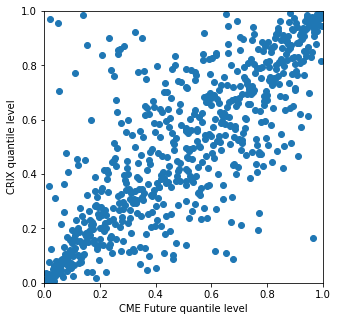

In [66]:
plt.figure(figsize=(5,5))
plt.scatter(u,v)
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('CME Future quantile level')
plt.ylabel('CRIX quantile level')

Text(0, 0.5, 'CRIX')

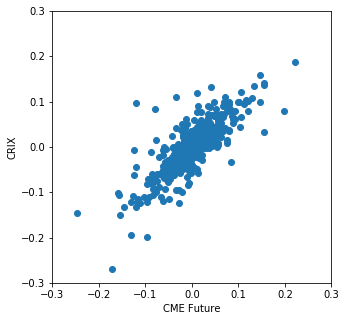

In [108]:
plt.figure(figsize=(5,5))
plt.scatter(future[:],CRIX[:])
plt.xlim((-0.3,0.3))
plt.ylim((-0.3,0.3))
plt.xlabel('CME Future')
plt.ylabel('CRIX')

Optimization terminated successfully.
         Current function value: -0.631462
         Iterations: 98
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 0.013352
         Iterations: 96
         Function evaluations: 202


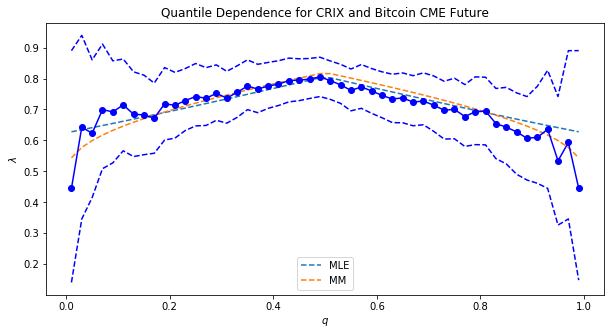

In [30]:
from copulae1 import *
q_arr = np.linspace(0.01,.99,50)
L_arr = []

for _ in range(2000):
    _id = np.random.choice(range(len(u)),len(u), True)
    _u = u[_id]
    _v = v[_id]
    L = np.array([empirical_lambda(_u,_v,q) for q in q_arr])
    L_arr.append(L)
    
L_arr = np.array(L_arr)

plt.figure(figsize=(10,5))
# plt.plot(q_arr, L, 'bo', label='Empirical')

# C = Gaussian_Mix_Independent({'rho':0.9, 'p':0.9}, stats.uniform, stats.uniform)
C = t_Copula({'rho':0.8, 'nu':2}, stats.uniform, stats.uniform, 2)
C.canonical_calibrate(u,v)
L_C = np.array([C._lambda(q) for q in q_arr])
plt.plot(q_arr, L_C, '--', label="MLE")

# C = Gaussian_Mix_Independent({'rho':0.9, 'p':0.9}, stats.uniform, stats.uniform)
C.mm_calibrate(u,v,[0.05,0.1,0.9,0.95])
L_C = np.array([C._lambda(q) for q in q_arr])
plt.plot(q_arr, L_C, '--', label="MM")

L = np.array([empirical_lambda(u,v,q) for q in q_arr])
LQ = np.quantile(np.array(L_arr), 0.05, axis=0)
UQ = np.quantile(np.array(L_arr), 0.95, axis=0)
plt.plot(q_arr, LQ , 'b--')
plt.plot(q_arr, np.quantile(np.array(L_arr), 0.5, axis=0), 'b-o')
plt.plot(q_arr, UQ, 'b--')
plt.title('Quantile Dependence for CRIX and Bitcoin CME Future')
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$q$')
plt.legend()

In [118]:
results.reset_index(inplace=True)
results.columns = ['Date', 'CRIX', 'future', 'log return CRIX', 'log return future']

In [136]:
train_size = 300
test_size = 100
step_size = 5

In [137]:
import os
data_name = "CRIX_future_v5"
if os.path.exists("../processed_data/%s/" %data_name )==False:
    os.mkdir("../processed_data/%s/" %data_name)
    os.mkdir("../processed_data/%s/train/" %data_name)
    os.mkdir("../processed_data/%s/test/" %data_name)

In [138]:
n = int(np.floor((len(results) - train_size - test_size)/step_size))
train_set = []
test_set = []

for i in range(n):
    data = results.iloc[(i*step_size):((i)*step_size)+train_size+test_size]
    test = data.iloc[:test_size,]
    train = data.iloc[test_size:,]
    train_set.append(train)
    test_set.append(test)

for i in range(len(train_set)):
    train_set[i].to_csv("../processed_data/%s/train/" %data_name +str(i)+".csv")
    test_set[i].to_csv("../processed_data/%s/test/" %data_name +str(i)+".csv")

In [122]:
print(np.mean([len(t) for t in test_set]))
test_set[-1].tail()


100.0


,Date,CRIX,future,log return CRIX,log return future
360,2019-04-09,13549.16019,5220.0,-0.020816,0.000958
361,2019-04-08,13834.15546,5215.0,0.039226,0.039106
362,2019-04-05,13302.00450,5015.0,0.034590,0.035519
363,2019-04-04,12849.75134,4840.0,-0.018295,-0.062082
364,2019-04-03,13086.99518,5150.0,0.015079,0.075603


In [104]:
print(np.mean([len(t) for t in train_set]))
train_set[-1].head()

300.0


,CRIX,future,log return CRIX,log return future
date,,,,
2019-04-02,12891.13607,4775.0,0.159347,0.146328
2019-04-01,10992.27916,4125.0,0.011921,0.011214
2019-03-29,10862.01323,4079.0,0.019671,0.017061
2019-03-28,10650.43764,4010.0,-0.005425,0.001248
2019-03-27,10708.37849,4005.0,0.030994,0.025286


In [105]:
test_set[-2].tail()


,CRIX,future,log return CRIX,log return future
date,,,,
2019-04-16,13372.832934,5200.0,0.027834,0.037223
2019-04-15,13005.747358,5010.0,-0.005888,-0.010918
2019-04-12,13082.555227,5065.0,0.004049,-0.001972
2019-04-11,13029.694868,5075.0,-0.062498,-0.064846
2019-04-10,13870.008932,5415.0,0.023404,0.036675


In [106]:
test_set[-3].tail()


,CRIX,future,log return CRIX,log return future
date,,,,
2019-04-24,13420.767087,5435.0,-0.028297,-0.029907
2019-04-23,13805.953481,5600.0,0.013535,0.037294
2019-04-22,13620.353141,5395.0,-0.000301,0.016823
2019-04-18,13624.448683,5305.0,0.016722,0.012328
2019-04-17,13398.518613,5240.0,0.001919,0.007663


In [110]:
# np.cov(results.iloc[:,-1],
# Check difference between 1 hour difference , if small then use
# Check % return between the last and next open, argue small difference between 1 hour lag
# Take the crix at mid night, take
# statistics of relative difference


date
2020-09-11    0.002421
2020-09-10   -0.000485
2020-09-09    0.030000
2020-09-08   -0.058655
2020-09-04   -0.009372
2020-09-03   -0.066752
2020-09-02   -0.052274
2020-09-01    0.020076
2020-08-31    0.017473
2020-08-28    0.025252
2020-08-27   -0.025252
2020-08-26    0.016472
2020-08-25   -0.042778
2020-08-24    0.006723
2020-08-21   -0.016308
2020-08-20    0.017574
2020-08-19   -0.028710
2020-08-18   -0.035063
2020-08-17    0.047445
2020-08-14    0.028218
2020-08-13   -0.005538
2020-08-12    0.018868
2020-08-11   -0.047759
2020-08-10    0.035711
2020-08-07   -0.036123
2020-08-06    0.015801
2020-08-05    0.038450
2020-08-04   -0.018555
2020-08-03   -0.000427
2020-07-31    0.022473
                ...   
2018-02-21   -0.124936
2018-02-20    0.154293
2018-02-16   -0.006434
2018-02-15    0.080618
2018-02-14    0.068611
2018-02-13   -0.017599
2018-02-12    0.032602
2018-02-09    0.033701
2018-02-08    0.013317
2018-02-07    0.084522
2018-02-06    0.041983
2018-02-05   -0.171195
2018-0

In [140]:
future_data.head()

,Date,Open,High,Low,Close,Open Interest,SMAVG (15)
0,2021-02-04,38080.0,39655.0,37685.0,38220.0,NaN,NaN
1,2021-02-03,36360.0,38155.0,36240.0,37790.0,2795.0,2091.0
2,2021-02-02,34205.0,36665.0,34070.0,36535.0,2755.0,2010.0
3,2021-02-01,33715.0,35280.0,32800.0,34265.0,2647.0,1929.0
4,2021-01-29,33995.0,39530.0,32590.0,35180.0,2635.0,1853.0


In [173]:
CRIX_data =  pd.read_json('../data/crix.json')

In [174]:
new_future_CRIX = future_data.merge(CRIX_data, left_on='Date', right_on='date', how='inner')
new_future_CRIX.sort_values('Date', ascending=False, inplace=True)

In [175]:
future = new_future_CRIX.Open
CRIX = new_future_CRIX.price

In [176]:
log_return_future = np.log(future/future.shift(-1))
log_return_CRIX =  np.log(CRIX/CRIX.shift(-1))

In [177]:
new_future_CRIX.loc[:,'log return future'] = log_return_future
new_future_CRIX.loc[:,'log return CRIX'] = log_return_CRIX
new_future_CRIX.dropna(inplace=True)

In [178]:
new_future_CRIX

,Date,Open,High,Low,Close,Open Interest,SMAVG (15),date,price,log return future,log return CRIX
0,2020-09-14,10315.0,10805.0,10270.0,10705.0,7058.0,6678.0,2020-09-14,30037.716520,-0.005318,0.001040
1,2020-09-11,10370.0,10420.0,10215.0,10340.0,6472.0,6479.0,2020-09-11,30006.484814,0.008230,0.011578
2,2020-09-10,10285.0,10565.0,10215.0,10315.0,7063.0,6319.0,2020-09-10,29661.064542,0.022119,0.010107
3,2020-09-09,10060.0,10385.0,9850.0,10320.0,5947.0,6116.0,2020-09-09,29362.798925,-0.035640,-0.023130
4,2020-09-08,10425.0,10475.0,9890.0,10015.0,5966.0,5981.0,2020-09-08,30049.874286,-0.033486,0.014601
5,2020-09-04,10780.0,10785.0,9905.0,10620.0,6348.0,5835.0,2020-09-04,29614.314902,-0.059423,-0.109754
6,2020-09-03,11440.0,11530.0,10460.0,10720.0,6589.0,5651.0,2020-09-03,33049.664458,-0.058978,-0.046514
7,2020-09-02,12135.0,12175.0,11165.0,11460.0,7528.0,5434.0,2020-09-02,34623.237089,0.031815,0.023061
8,2020-09-01,11755.0,12200.0,11625.0,12075.0,8739.0,5145.0,2020-09-01,33833.920615,0.001703,-0.001434
9,2020-08-31,11735.0,11915.0,11705.0,11835.0,8266.0,4774.0,2020-08-31,33882.473739,0.027210,0.033484


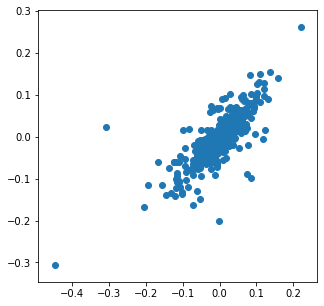

In [180]:
plt.figure(figsize=(5,5))
plt.scatter(log_return_CRIX, log_return_future)

In [181]:
new_future_CRIX.to_csv('../data/btc future and reference rate/CRIX_future_v2.csv')

In [191]:
import os
filename = 'CRIX_future_Open_v4'
path = "../processed_data/"+ filename+"/"
if not os.path.exists(path):
    os.mkdir(path)
    os.mkdir(path+'train/')
    os.mkdir(path+'test/')
    
train_size = 300
test_size = 100 
step_size = 5

df = new_future_CRIX.copy()

n = int(np.floor((len(df)-train_size-test_size)/step_size))

train_set = []
test_set = []


for i in range(n):
    data = df.iloc[(i*step_size):((i)*step_size)+train_size+test_size]
    test = data.iloc[:test_size,]
    train = data.iloc[test_size:,]
    train_set.append(train)
    test_set.append(test)

for i in range(len(train_set)):
    train_set[i].to_csv(path+'train/'+str(i)+".csv")
    test_set[i].to_csv(path+'test/'+str(i)+".csv")

In [192]:
test_set[0].tail()

,Date,Open,High,Low,Close,Open Interest,SMAVG (15),date,price,log return future,log return CRIX
95,2020-04-29,7810.0,9085.0,7805.0,8860.0,2124.0,1388.0,2020-04-29,18379.326121,-0.003196,0.002615
96,2020-04-28,7835.0,7875.0,7760.0,7785.0,1935.0,1314.0,2020-04-28,18331.330183,0.017381,0.008668
97,2020-04-27,7700.0,7910.0,7680.0,7795.0,1881.0,1253.0,2020-04-27,18173.115650,-0.001946,0.041941
98,2020-04-24,7715.0,7720.0,7500.0,7610.0,1666.0,1198.0,2020-04-24,17426.675218,0.069085,0.035459
99,2020-04-23,7200.0,7855.0,7130.0,7660.0,1598.0,1156.0,2020-04-23,16819.578224,0.046917,0.040012


In [193]:
train_set[0].head()

,Date,Open,High,Low,Close,Open Interest,SMAVG (15),date,price,log return future,log return CRIX
100,2020-04-22,6870.0,7235.0,6840.0,7160.0,1269.0,1114.0,2020-04-22,16159.883185,-0.003632,-0.001801
101,2020-04-21,6895.0,6975.0,6830.0,6910.0,1242.0,1094.0,2020-04-21,16189.010410,-0.048825,-0.038894
102,2020-04-20,7240.0,7290.0,6800.0,6825.0,1247.0,1071.0,2020-04-20,16831.066907,0.005540,0.013048
103,2020-04-17,7200.0,7280.0,7075.0,7125.0,1202.0,1009.0,2020-04-17,16612.879370,0.064539,0.065767
104,2020-04-16,6750.0,7235.0,6490.0,7155.0,1194.0,965.0,2020-04-16,15555.449131,-0.028479,-0.032579
